<a href="https://colab.research.google.com/github/Ademola-Olorunnisola/Ademola-Olorunnisola.github.io/blob/main/MYEKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

from scipy.integrate import odeint
import copy

In [47]:

try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

In [48]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/Ademola-Olorunnisola/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

tb_simulations = import_local_or_github('tb_simulations', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

$$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) = \mathbf{f_0}(\mathbf{x}) + \mathbf{f_1}(\mathbf{x})\bbox[lightgreen]{\alpha} + \mathbf{f_2}(\mathbf{x})\bbox[lightgreen]{\kappa}
$$

$$
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{S} \\[0.3em]
\bbox[yellow]{V} \\[0.3em]
\bbox[yellow]{I} \\[0.3em]
\bbox[yellow]{R} \\[0.3em]
\bbox[pink]{\beta} \\[0.3em]
\bbox[pink]{\sigma}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[lightblue]{\Lambda} - \bbox[pink]{\beta}\bbox[yellow]{SI} - \bbox[lightblue]{\mu}\bbox[yellow]{S} \\[0.3em]
0 - \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} - \bbox[lightblue]{\mu}\bbox[yellow]{V} \\[0.3em]
\bbox[pink]{\beta}\bbox[yellow]{SI} + \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} - \bbox[lightblue]{\gamma}\bbox[yellow]{I} - \bbox[lightblue]{\mu}\bbox[yellow]{I} \\[0.3em]
\bbox[lightblue]{\gamma}\bbox[yellow]{I} - \bbox[lightblue]{\mu}\bbox[yellow]{R}\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
-\bbox[yellow]{S} \\[0.3em]
\bbox[yellow]{S} \\[0.3em]
0 \\[0.3em]
0\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{\alpha} +
\overset{f_2}{\begin{bmatrix}
\bbox[pink]{\beta}\bbox[yellow]{SI} \\[0.3em]
\bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} \\[0.3em]
-\bbox[pink]{\beta}\bbox[yellow]{SI} - \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} \\[0.3em]
0\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{\kappa}
$$

In [49]:
Lambda = 9.04e-5
mu = 4.3e-5
gamma = 0.00555
N = 223000000
REPORTING_RATE = 0.60

In [50]:
def f_perturbed(x_vec, u_vec, return_state_names=False):
    """
    SVIR dynamics with time-varying perturbations to make parameters observable.
    """
    if return_state_names:
        return ['S', 'V', 'I', 'R', 'beta', 'sigma']

    x_vec = np.asarray(x_vec, dtype=float)
    u_vec = np.asarray(u_vec, dtype=float)

    S, V, I, R, beta, sigma = x_vec

    # Extract controls (now includes time as 3rd element)
    alpha = u_vec[0]
    kappa = u_vec[1]
    t = u_vec[2] if len(u_vec) > 2 else 0

    # PERTURBATION 1: Seasonal variation in beta (±15% amplitude, 90-day period)
    beta_seasonal = 0.15 * np.sin(2 * np.pi * t / 90)
    beta_actual = beta * (1 + beta_seasonal)

    # PERTURBATION 2: Slow drift in sigma (±10% amplitude, 180-day period)
    sigma_drift = 0.10 * np.sin(2 * np.pi * t / 180 + np.pi/4)  # Phase shifted
    sigma_actual = sigma * (1 + sigma_drift)

    # Effective transmission rate
    beta_eff = beta_actual * (1.0 - kappa)

    # State derivatives
    dS = Lambda - beta_eff * S * I - mu * S - alpha * S
    dV = alpha * S - sigma_actual * beta_eff * V * I - mu * V
    dI = beta_eff * S * I + sigma_actual * beta_eff * V * I - gamma * I - mu * I
    dR = gamma * I - mu * R

    dbeta = 0.0
    dsigma = 0.0

    return np.array([dS, dV, dI, dR, dbeta, dsigma])



In [51]:
def u_func_perturbed(x_vec, t):
    """
    Control policy with sinusoidal perturbations for richer dynamics.
    """
    I = x_vec[2]
    I_threshold = 0.005

    # Base control policy
    if I > I_threshold:
        alpha_base = 0.01
        kappa_base = 0.3
    else:
        alpha_base = 0.005
        kappa_base = 0.1

    # PERTURBATION 3: Add oscillations to controls
    alpha = alpha_base + 0.003 * np.sin(2 * np.pi * t / 30)  # 30-day cycle
    kappa = kappa_base + 0.15 * np.sin(2 * np.pi * t / 45)   # 45-day cycle

    # Keep in valid range
    alpha = np.clip(alpha, 0.001, 0.02)
    kappa = np.clip(kappa, 0.0, 0.6)

    return np.array([alpha, kappa, t])  # Include time


In [52]:
def f_ode_perturbed(x_vec, t):
    """Wrapper for odeint"""
    u_vec = u_func_perturbed(x_vec, t)
    return f_perturbed(x_vec, u_vec)

In [53]:
def h_normalized(x_vec, u_vec, return_measurement_names=False):
    if return_measurement_names:
        return ['V_norm', 'I_reported_norm', 'R_norm']

    x_vec = np.asarray(x_vec, dtype=float)
    V, I, R = x_vec[1], x_vec[2], x_vec[3]

    return np.array([V, I * REPORTING_RATE, R])


In [54]:
x0_true = np.array([
    40000000/N,      # S = 0.179 (reduced)
    150000000/N,     # V = 0.673
    8000000/N,       # I = 0.036 (MUCH HIGHER - active outbreak!)
    25000000/N,      # R = 0.112 (more recovered)
    0.00003,         # beta (TRUE value to estimate)
    0.85             # sigma (TRUE value to estimate)
])


In [55]:
x0_filter = np.array([
    50000000/N,      # S guess
    145000000/N,     # V guess
    10000000/N,      # I guess
    18000000/N,      # R guess
    0.00005,         # beta guess (wrong!)
    0.70             # sigma guess (wrong!)
])


In [56]:
t_sim = np.arange(0, 365, 1.0)
result = odeint(f_ode_perturbed, x0_true, t_sim)

In [57]:
x_sim = {
    'S': result[:, 0],
    'V': result[:, 1],
    'I': result[:, 2],
    'R': result[:, 3],
    'beta': result[:, 4],
    'sigma': result[:, 5]
}


In [58]:
u_sim = {'alpha': [], 'kappa': [], 't': []}
for i in range(len(t_sim)):
    u = u_func_perturbed(result[i], t_sim[i])
    u_sim['alpha'].append(u[0])
    u_sim['kappa'].append(u[1])
    u_sim['t'].append(u[2])


In [59]:
measurement_noise_stds_norm = {
    'V': 2000000.0 / N,
    'I': 50000.0 / N,      # Increased noise for larger I
    'R': 500000.0 / N
}

In [60]:
np.random.seed(42)

y_noisy_norm = {}
y_noisy_norm['V'] = (
    x_sim['V'] +
    np.random.normal(0, measurement_noise_stds_norm['V'], len(t_sim))
)


In [61]:
y_noisy_norm['I_reported'] = np.maximum(
    x_sim['I'] * REPORTING_RATE +
    np.random.normal(0, measurement_noise_stds_norm['I'], len(t_sim)),
    0
)


In [62]:
y_noisy_norm['R'] = (
    x_sim['R'] +
    np.random.normal(0, measurement_noise_stds_norm['R'], len(t_sim))
)


In [63]:
y_noisy_df = pd.DataFrame({
    'V_norm': y_noisy_norm['V'],
    'I_reported_norm': y_noisy_norm['I_reported'],
    'R_norm': y_noisy_norm['R']
})


In [64]:
u_sim_df = pd.DataFrame(u_sim)
u0 = np.array([u_sim['alpha'][0], u_sim['kappa'][0], u_sim['t'][0]])


In [65]:
P0 = np.diag([
    0.01,      # S
    0.01,      # V
    0.005,     # I (higher uncertainty due to higher value)
    0.02,      # R
    0.000015,  # beta (moderate uncertainty - we want to estimate this!)
    0.15       # sigma (moderate uncertainty - we want to estimate this!)
])

# Increased process noise for parameters (they vary over time)
Q = np.diag([
    1e-6,      # S
    1e-6,      # V
    1e-6,      # I (increased for larger values)
    1e-6,      # R
    1e-11,     # beta (small random walk - allows adaptation)
    1e-9       # sigma (small random walk - allows adaptation)
])

R = np.diag([
    measurement_noise_stds_norm['V']**2,
    measurement_noise_stds_norm['I']**2,
    measurement_noise_stds_norm['R']**2
])


In [66]:
import sys
sys.path.append('../Utility')
import extended_kalman_filter

EKF = extended_kalman_filter.EKF(
    f_perturbed,
    h_normalized,
    x0_filter,
    u0,
    P0,
    Q,
    R,
    dynamics_type='continuous',
    discretization_timestep=1.0,
    circular_measurements=(0, 0, 0)
)

EKF.estimate(y_noisy_df, u_sim_df)


In [67]:
x_est = pd.DataFrame(
    np.vstack(EKF.history['X']),
    columns=f_perturbed(None, None, return_state_names=True)
)

In [68]:
P_diags = np.vstack([
    np.diag(EKF.history['P'][i])
    for i in range(len(EKF.history['P']))
])
P_diags = pd.DataFrame(
    P_diags,
    columns=f_perturbed(None, None, return_state_names=True)
)

In [69]:
beta_true = x0_true[4]
beta_init = x0_filter[4]
beta_final = x_est['beta'].iloc[-1]
beta_error = abs(beta_final - beta_true) / beta_true * 100


In [70]:
sigma_true = x0_true[5]
sigma_init = x0_filter[5]
sigma_final = x_est['sigma'].iloc[-1]
sigma_error = abs(sigma_final - sigma_true) / sigma_true * 100

In [71]:
state_names = ['S', 'V', 'I', 'R']
for state in state_names:
    rmse = np.sqrt(np.mean((x_sim[state] - x_est[state].values)**2))

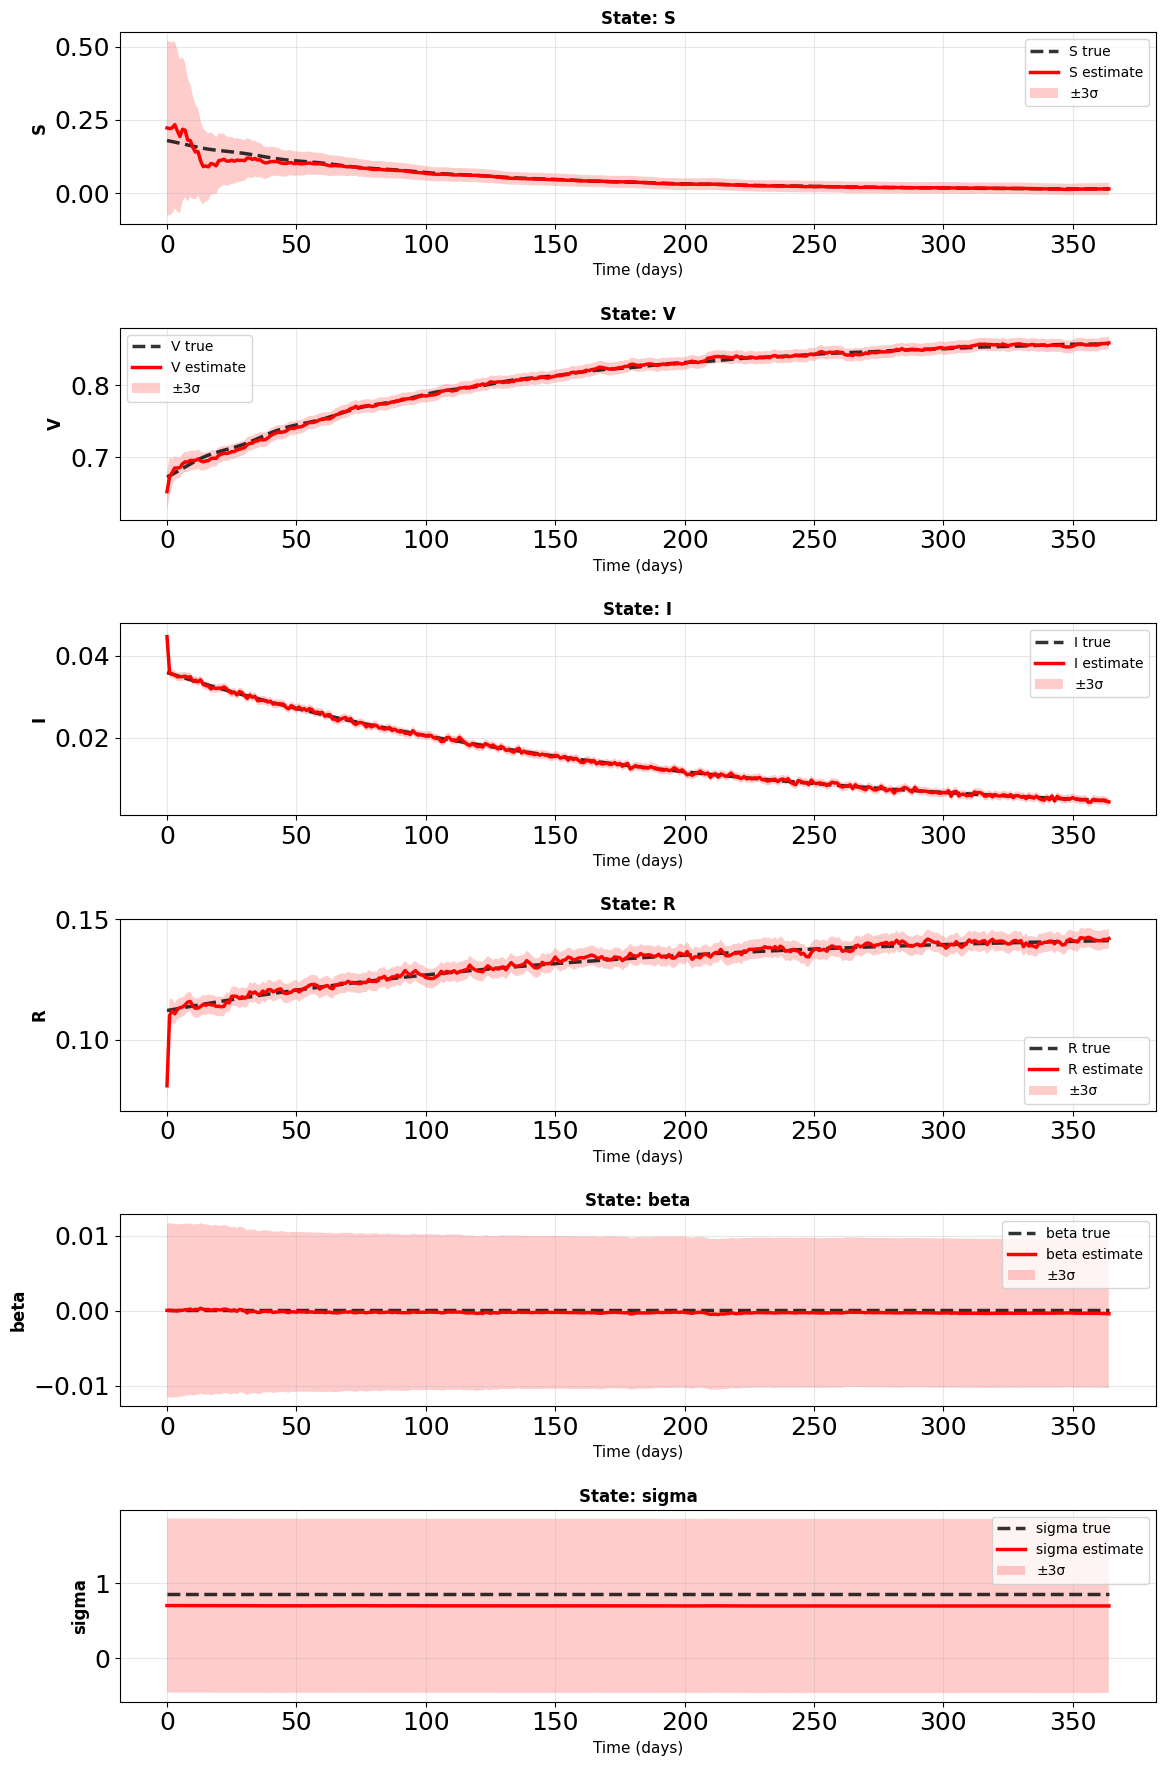

In [74]:
state_names = f_perturbed(None, None, return_state_names=True)
n_states = len(state_names)

fig, axes = plt.subplots(n_states, 1, figsize=(12, 3*n_states), dpi=100)

for i, state in enumerate(state_names):
    ax = axes[i]
    x_est_col = x_est[state].values
    P_diag_col = P_diags[state].values

    ax.plot(t_sim, x_sim[state], 'k--', linewidth=2.5, label=f'{state} true', alpha=0.8)
    ax.plot(t_sim, x_est_col, 'r-', linewidth=2.5, label=f'{state} estimate')

    plus_3sigma = x_est_col + 3 * np.sqrt(P_diag_col)
    minus_3sigma = x_est_col - 3 * np.sqrt(P_diag_col)
    ax.fill_between(t_sim, plus_3sigma, minus_3sigma,
                    facecolor='red', alpha=0.2, label='±3σ')

    ax.set_xlabel('Time (days)', fontsize=11)
    ax.set_ylabel(state, fontsize=12, fontweight='bold')
    ax.set_title(f'State: {state}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.savefig('ekf_all_states_vertical.png', dpi=150, bbox_inches='tight')
plt.show()